<a href="https://colab.research.google.com/github/da2985/e6885-adnet/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Starting Configs

Please use the following two lines to load from Google Drive

If your file is not there, upload it to https://drive.google.com/drive/folders/1tsPKyB2E1nW8Qw--kZ9GaeGW2u2-XoV6?usp=sharing

In [59]:
# This must be run within a Google Colab environment 
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
import sys
import os

sys.path.append('/content/gdrive/EE6885')

os.chdir("/content/gdrive/My Drive/EE6885")

In [61]:
!ls adnet_datasets/OTB

 Basketball   Car24	 Dog1	      Human5	     MountainBike   Surfer
 Bird2	      Car4	 Doll	      Human6	     Panda	    Suv
 BlurBody     CarDark	 DragonBaby   Human7	     RedTeam	    Sylvester
 BlurCar1     CarScale	 Dudek	      Human8	     Rubik	    Tiger1
 BlurCar2     ClifBar	 FaceOcc1     Human9	     Shaking	    Tiger2
 BlurCar3     Coke	 FaceOcc2     Ironman	     Singer1	    Toy
 BlurCar4     Couple	 Fish	      Jogging	     Singer2	    Trans
 BlurFace     Coupon	 FleetFace    Jump	     Skater	    Trellis
 BlurOwl      Crossing	 Football1    Jumping	     Skater2	    Twinnings
 Board	      Crowds	 Freeman1     KiteSurf	    'Skater2 (1)'   Vase
 Bolt	      Dancer	 Girl	      Lemming	     Skating1	    Walking
 Bolt2	      Dancer2	 Girl2	      Liquor	     Skating2	    Walking2
 Box	      David2	 Gym	      Man	     Skating3	    Woman
 Boy	      David3	 Human2       Matrix	     Skiing
 Car1	      Deer	 Human3       Mhyang	     Soccer
 Car2	      Dog	 Human4       MotorRolling   Subway


In [62]:
pip install hdf5storage tensorflow-addons

In [63]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
import tensorflow.experimental.numpy as tnp

import cv2
import glob
import hdf5storage
import math
import random
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import scipy.io as sio

import linecache

from typing import Dict, List, Tuple
from operator import add
import copy

from numpy.random import seed
from datetime import datetime

In [64]:
 %load_ext autoreload 
 %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configurations

In [ ]:
#@markdown Network configurations
LEARNING_RATE = 1e-4 #@param {type:"number"}
GOAL_IOU = 0.7 #@param {type:"number"}

# The length of the action buffer
L = 10 #@param {type:"number"}
# Max Trajectory Length 
MAX_TRAJECTORY_LENGTH =  10#@param {type:"number"}
POLICY_TYPE = "stochastic" #@param ["deterministic", "stochastic"] {type:"string"}
DROPOUT_4 = 0.5 #@param {type:"number"}
DROPOUT_5 = 0.5 #@param {type:"number"}
N_EPOCHS =  3#@param {type:"number"}

# Number of retries to collect sequence loss sum (to reduce variance)
N_RETRIES =   1#@param {type:"number"}

# Randomizes the order in which frames are trained on from a video clip
RANDOMIZE_TRAINING = False #@param {type:"boolean"}

# The paper uses sum. I thought avg would help address giant swings, but the training was taking way too long
# with negligible updates
GRAD_ACCUM_SCHEME = "sum" #@param ["avg", "sum"] {type:"string"}

# Use to avoid overly long trajectories. 
# During trajectory collection, we were not receiving 
# enough positvie signals
PREMATURE_BREAK = False #@param {type:"boolean"}


#@markdown ---
#@markdown Loss/Reward Constants
# This is a probability offset for adding noise since log(P(a|s)=1)=0
PROB_OFFSET = 1e-5 #@param {type:"number"} 
# This is the discount factor
GAMMA = 1 #@param {type:"number"}

# final_bbox is used in original Ad Net where  the final bounding box placement 
# is used in reward calculationfor all actions in a trajectory
# individ_bbox individually assign rewards per each bounding box.
# only_final_bbox only gives a reward to the final action
REWARD_SCHEME = "only_final_bbox" #@param ["only_final_bbox", "final_bbox", "individ_bbox"] {type:"string"}

#@markdown ---
#@markdown Bounding Box/Patch Constants (probably avoid touching)
ALPHA = 0.03 #@param {type:"number"}
MIN_WINDOW_SIZE = 10 #@param {type:"number"}
PATCH_X = 112 #@param {type:"number"}
PATCH_Y = 112 #@param {type:"number"}
N_CHANNELS = 3 #@param {type:"number"}

#@markdown ---
RANDOM_SEED = 6885







In [66]:
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

DATASET_PATH = "adnet_datasets/OTB/*" #@param {type:"string"}
ALL_DATASETS_LIST = glob.glob(DATASET_PATH)

### Successful Configurations (Minimize Me Please)

In [67]:
### SUCCESSFUL CONFIGS

# 12/18 4:41 PM
# #@markdown Network configurations
# LEARNING_RATE = 1e-4 #@param {type:"number"}
# # The length of the action buffer
# L = 10 #@param {type:"number"}
# # Max Trajectory Length 
# MAX_TRAJECTORY_LENGTH = 20 #@param {type:"number"}
# POLICY_TYPE = "stochastic" #@param ["deterministic", "stochastic"] {type:"string"}
# DROPOUT_4 = 0.5 #@param {type:"number"}
# DROPOUT_5 = 0.5 #@param {type:"number"}
# N_EPOCHS =  1#@param {type:"number"}

# # Number of retries to collect sequence loss sum (to reduce variance)
# N_RETRIES =  4 #@param {type:"number"}

# # Randomizes the order in which frames are trained on from a video clip
# RANDOMIZE_TRAINING = True #@param {type:"boolean"}
# GRAD_ACCUM_SCHEME = "sum" #@param ["avg", "sum"] {type:"string"}
# # The paper uses sum


# #@markdown ---
# #@markdown Loss/Reward Constants
# # This is a probability offset for adding noise since log(P(a|s)=1)=0
# PROB_OFFSET = 1e-5 #@param {type:"number"} 
# # This is the discount factor
# GAMMA = 0.99 #@param {type:"number"}
# REWARD_SCHEME = "final_bbox" #@param ["final_bbox", "individ_bbox"] {type:"string"}

# #@markdown ---
# #@markdown Bounding Box/Patch Constants (probably avoid touching)
# ALPHA = 0.03 #@param {type:"number"}
# MIN_WINDOW_SIZE = 10 #@param {type:"number"}
# PATCH_X = 112 #@param {type:"number"}
# PATCH_Y = 112 #@param {type:"number"}
# N_CHANNELS = 3 #@param {type:"number"}

# #@markdown ---
# RANDOM_SEED = 6885







## Model Definitions

In [68]:
class ADNET(tf.keras.Model):

    ACTION_DIM = 11
    K = 10
    CONF_SCORE_DIM = 2

    def __init__(self):
        super(ADNET, self).__init__()

        self.action_history = tf.keras.layers.Input(shape = (1,1, ADNET.ACTION_DIM * ADNET.K))

        self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (7, 7), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_1')
        self.max1  = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (1, 1), padding = 'VALID')
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_2')
        self.max2  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (2, 2), padding = 'VALID')
        self.conv3 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_3')
        self.max3  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (1, 1), padding = 'VALID')
        
        self.fc1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'VALID', activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (1,1), padding = 'VALID', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Conv2D(filters = 11, kernel_size = (1,1), padding = 'VALID', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Conv2D(filters = 2, kernel_size = (1,1), padding = 'VALID', name = 'fc4',activation="softmax")

        # TODO: ADD A SEED
        self.dropout1=tf.keras.layers.Dropout(DROPOUT_4)
        self.dropout2=tf.keras.layers.Dropout(DROPOUT_5)
        

    def build(self):
      super(ADNET, self).build((None, 112, 112, 3))
      self.action_history = np.zeros(shape = (1,1,1,110))


    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]


    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def getEmbedding(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        return tf.reshape(x,(-1,))

    def getFC1(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.fc1(x)
        return x

    def setActionHistory(self, action_history):
      self.action_history = action_history.reshape(
          (1, 1, 1, ADNET.ACTION_DIM * ADNET.K))

    def updateActionHistory(self, a: int=8) -> tnp.ndarray:
      '''
      Left-to-right FIFO queue of actions
      '''
      ah = np.array(self.action_history).flatten()
      ah[ADNET.ACTION_DIM:] = ah[:-ADNET.ACTION_DIM]
      ah[:ADNET.ACTION_DIM] = 0 
      ah[a] = 1
      self.setActionHistory(ah)
      return ah

    def clearActionHistory(self):
      self.action_history = tf.zeros((1, 1, 1, ADNET.ACTION_DIM * ADNET.K))

    def getPrettyActionHistory(self):
      action_hist = tf.reshape(model.action_history, [-1])
      sbuffer = "["
      for i, x in enumerate(action_hist):
        if i > 0 and i % model.ACTION_DIM == 0:
          sbuffer+= "\x1b[35m,\x1b[0m"
        if x == 1:
          sbuffer += "\x1b[35m{0}\x1b[0m".format(int(x))
        else:
          sbuffer += "{0}".format(int(x))
      sbuffer += "]"
      return sbuffer 


    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

def setAllWeights(model, weights):
  model.layers[0].set_weights([weights["conv1f"], tf.reshape(weights["conv1b"],(96,))])
  model.layers[2].set_weights([weights["conv2f"], tf.reshape(weights["conv2b"],(256,))])
  model.layers[4].set_weights([weights["conv3f"], tf.reshape(weights["conv3b"],(512,))])
  model.layers[6].set_weights([weights["fc4f"], tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"], tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"], tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"], tf.zeros(2)])


def setWeights(model, weights, weights2):
  model.layers[0].set_weights([weights2["conv1f"],tf.reshape(weights2["conv1b"],(96,))])
  model.layers[2].set_weights([weights2["conv2f"],tf.reshape(weights2["conv2b"],(256,))])
  model.layers[4].set_weights([weights2["conv3f"],tf.reshape(weights2["conv3b"],(512,))])
  
  model.layers[6].set_weights([weights["fc4f"],tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"],tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"],tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"],tf.zeros(2)])
  
  return model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [69]:
class ADNET_v2(tf.keras.Model):
    def __init__(self):
        super(ADNET_v2, self).__init__()

        #self.action_history = tf.keras.layers.Input(shape = (1,1,110))
        self.action_history = tf.keras.layers.Input(shape = (110))

        self.resnet=tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling="max")
        #self.resnet = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling=None)
        #self.conv1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (4,4), padding = 'VALID', name = 'fc4',activation="relu")
        
        self.fc1 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform',activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Dense(11,kernel_initializer='glorot_uniform', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Dense(2,kernel_initializer='glorot_uniform',name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(0)
        self.dropout2=tf.keras.layers.Dropout(0)
        

    def build(self, action_history):
      super(ADNET_v2, self).build((None, 112, 112, 3))
      self.action_history=action_history
      self.resnet.trainable = False


    def setActionHistory(self, action_history):
      self.action_history=action_history


    def call(self, input_tensor, training=False):
        x = self.resnet(input_tensor)
        #x = self.conv1(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

     
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

# Helper Functions

### Plotting & Debugging

[171 128  99 316]


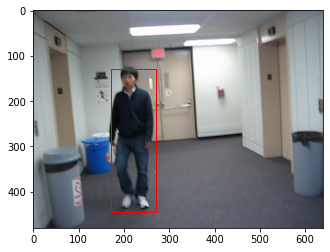

In [70]:
def get_ground_truths(ground_truth_file: str) -> np.array:
  '''
  Use me to convert a ground_truth_file to a numpy array
  '''
  with open(ground_truth_file) as f:
    ground_truths = f.readlines()
    to_nparray = lambda s: np.array(re.findall('\d+', s), dtype=int)
    truths = list(map(to_nparray, ground_truths))
    return np.asarray(truths)
  return None

def plotNpImageBBox(img: np.array, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x, y, w, h = bbox
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.imshow(img)
  return bbox

def plotNpImageBBoxes(img: np.array, src_bbox: np.array, target_bbox: np.array, 
                      pred_bbox: np.array) -> np.array:
  '''
  Plots the bounding boxes on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x1, y1, w1, h1 = src_bbox
  x2, y2, w2, h2 = target_bbox
  x3, y3, w3, h3 = pred_bbox
  rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=1, edgecolor='b', facecolor='none')
  rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=1, edgecolor='g', facecolor='none')
  rect3 = patches.Rectangle((x3, y3), w3, h3, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_patch(rect3)
  plt.imshow(img)
  return pred_bbox  

def plotImageBBox(img: str, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image (from given filepath) and returns the 
  bounding box
  '''
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plotNpImageBBox(img, bbox)
  return bbox

def plotDatasetImageBBox(dataset: str, frame_no: int) -> Tuple[np.array, int]:
  '''
  Plot an image's bounding box. Returns the ground truth and frame number.
  WORKS FOR OTB100
  '''
  imgs = sorted(glob.glob("{0}/img/*".format(dataset)))
  gt = get_ground_truths("{0}/groundtruth_rect.txt".format(dataset))
  plotImageBBox(imgs[frame_no], gt[frame_no])
  return gt[frame_no], frame_no


# print(plotDatasetImageBBox("adnet_datasets/OTB/Basketball", 50)[0])
print(plotDatasetImageBBox("adnet_datasets/OTB/BlurBody", 10)[0])

### Movement

In [71]:
STOP_ACTION_INDEX = 8

def getFrame(f_path: str) -> np.array:
  print("Frame path: {0}".format(f_path))
  img = cv2.imread(f_path)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def calculate_IOU(bbox1: np.array, bbox2: np.array):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
           
    i_x1 = max(x1, x2)
    i_y1 = max(y1, y2)
    i_x2 = min(x1 + w1, x2 + w2)
    i_y2 = min(y1 + h1, y2 + h2)
    if i_x1 >= i_x2 or i_y1 >= i_y2:
      return 0.0

    intersection_area = (i_x2 - i_x1) * (i_y2 - i_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def move(image: np.array, bbox: np.array, action: str, 
         stride_magnitude: int=1) -> np.array:
  '''
  Returns the new bounding box after taking an action: 
  {"left", "right", "up", "down"}. Use stride to indicate the step size.
  '''
  if action not in set(["left", "right", "up", "down"]):
    raise RuntimeError("Invalid action taken :(") 
  
  x, y, w, h = bbox
  if action in set(["left", "right"]):
    step = max(1, int(ALPHA * w)) * stride_magnitude * (-1 if action=="left" else 1)
    x = min(max(0, int(x + step)), int(image.shape[1] - w - 1)) 
  else:
    step = max(1, int(ALPHA * h)) * stride_magnitude * (-1 if action=="up" else 1)
    y = min(max(0, int(y + step)), int(image.shape[0] - h - 1)) 

  return np.array([x, y, w, h])


def scale(image: np.array, bbox: np.array, scaleUp: bool):
  x, y, w, h = bbox
  deltaW, deltaH = max(2, ALPHA * w), max(2, ALPHA * h)
  if not scaleUp: 
    deltaW *= -1
    deltaH *= -1
  nw = min(image.shape[1], max(MIN_WINDOW_SIZE, int(w + deltaW))) 
  nh = min(image.shape[0], max(MIN_WINDOW_SIZE, int(h + deltaH)))
  

  x = max(0, min(int(x - deltaW / 2), int(image.shape[1] - w - 1)))
  y = max(0, min(int(y - deltaH / 2), int(image.shape[0] - h - 1)))
  return np.array([x, y, nw, nh])


def selectAction(img: np.array, bbox: np.array, index: int): 
  if index == 0 :
    bbox = move(img, bbox, "left")
  elif index == 1 :
    bbox = move(img, bbox, "left", stride_magnitude=2)
  elif index == 2 :
    bbox = move(img, bbox, "right")
  elif index == 3 :
    bbox = move(img, bbox, "right", stride_magnitude=2)  
  elif index == 4 :
    bbox = move(img, bbox, "up")  
  elif index == 5 :
    bbox = move(img, bbox, "up", stride_magnitude=2)
  elif index == 6 :
    bbox = move(img, bbox, "down")
  elif index == 7 :
    bbox = move(img, bbox, "down", stride_magnitude=2)
  elif index == 8:
    bbox = bbox
  elif index == 9 :
    bbox = scale(img, bbox, False)     
  elif index == 10 :
    bbox = scale(img, bbox, True)    
  else:
    raise ValueError("Invalid action provided: {0}".format(index))

  x, y, w, h = bbox
  # some of the data is just invalid :/
  # assert 0 <= x <= img.shape[1] - w, "x:{0}, w:{1} is out of bounds: [0, {2}]".format(x, w, img.shape[1])
  # assert 0 <= y <= img.shape[0] - h, "y:{0}, h:{1} is out of bounds: [0, {2}]".format(y, h, img.shape[0])
  # assert MIN_WINDOW_SIZE <= w <= img.shape[1], "w:{0}, is invalid".format(w)
  # assert MIN_WINDOW_SIZE <= h <= img.shape[0], "h:{0} is invalid".format(h)
  return index, bbox


def human_readable_action(index: int) -> str:
  '''
  Map action numbers to human readable strings
  '''
  def _get_action(index:int) -> str:
    if index == 0:
      return "left"
    elif index == 1:
      return "2x left"
    elif index == 2:
      return "right"
    elif index == 3:
      return "2x right"
    elif index == 4:
      return "up"
    elif index == 5:
      return "2x up"
    elif index == 6:
      return "down"
    elif index == 7:
      return "2x down"
    elif index == 8:
      return "stop"
    elif index == 9:
      return "scale down"
    elif index == 10 :
      return "scale up"
  return _get_action(index).upper()


def getAction(img: np.array, bbox: np.array, action_probs: np.array):  
  a = -1
  if POLICY_TYPE == "deterministic":
    a = tf.math.argmax(action_probs)
  else:
    action_probs = np.array(action_probs) + PROB_OFFSET
    action_probs /= action_probs.sum()
  
    a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
  return selectAction(img, bbox, a)


def isStop(action: int):
  return action == STOP_ACTION_INDEX


# REINFORCE Loop

### Trajectory Loss Function

TODO: investigate adding https://www.analyticsvidhya.com/blog/2020/11/baseline-for-policy-gradients/
Or rather https://arxiv.org/pdf/1301.2315.pdf

In [72]:
def getNonStopScore(bbox1: np.array, bbox2: np.array, gt: np.array) -> float:
  # Issues with this blowing up the gradient in the wrong direction

  def _dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
  
  prevIou = calculate_IOU(bbox1, gt) 
  nextIou = calculate_IOU(bbox2, gt)
  x1, y1 = bbox1[:2]
  x2, y2 = bbox2[:2]
  xg, yg = gt[:2]

  # if prevIou == nextIou: EXPERIMENTED WITH USING EUCLIDEAN DISTANCE
  #   return -1 * (_dist(x2, y2, xg, yg) - _dist(x1, y1, xg, yg))
  result = nextIou - prevIou 
  return result 

def seqLosses(action_probs: List[np.array], actions_taken: List[int], 
              bboxes: List[np.array], 
              target_bbox: np.array) -> np.array:

    assertMsg = "Invalid trajectory: actions taken ({0}) + 1 != Bboxes length ({1})".format(
              len(actions_taken), len(bboxes)) 
    assert len(actions_taken) + 1 == len(bboxes), assertMsg
          
    src_bbox = np.array(bboxes[0])
    end_bbox = np.array(bboxes[-1])
    print("\x1b[34m>> Calculating frame loss : {0} -> {1} (Target was {2})\x1b[0m".format(
            np.array2string(src_bbox, separator=', '),
            np.array2string(end_bbox, separator=', '),
            np.array2string(target_bbox, separator=', ')))
    rewards = np.zeros(len(actions_taken))
    discounts = np.zeros(len(actions_taken))
    for i, a in enumerate(actions_taken):
      prev_bbox = np.array(bboxes[i])
      next_bbox = np.array(bboxes[i+1])
      ###################### CHANGE REWARD CALCULATION HERE ####################
      if REWARD_SCHEME == "final_bbox":
        rewards[i] = 1 if calculate_IOU(end_bbox, target_bbox) > GOAL_IOU\
                      else -1      
      elif REWARD_SCHEME == "only_final_bbox" and i == len(actions_taken) - 1:
        rewards[i] = 1 if calculate_IOU(end_bbox, target_bbox) > GOAL_IOU\
                      else -1      
      else:
        if isStop(a):
          rewards[i] = 1 if calculate_IOU(next_bbox, target_bbox) > GOAL_IOU else -1
        else:
          rewards[i] = getNonStopScore(prev_bbox, next_bbox, target_bbox) 
      ###################### CHANGE REWARD CALCULATION UP ABOVE ################
      prob_a = action_probs[i][a]
      discounts[i] = GAMMA ** i
      print("   |->> t={0} {1}-Reward ({2}) for {3}:bbox transition: {4} -> {5} w/ P(a|s)={6} and iou={7} and reward={8} and discount={9}"
            .format(i+1, "Stop" if isStop(a) else "Diff", 
                    np.around(rewards[i], decimals=3), 
                    human_readable_action(a).upper(),
                    np.array2string(prev_bbox, separator=', '),
                    np.array2string(next_bbox, separator=', '), prob_a, 
                    calculate_IOU(next_bbox, target_bbox), 
                    rewards[i], discounts[i]), 
            )
    
    gather_idx = [[i, a] for i, a in enumerate(actions_taken)]
    p_a = tf.gather_nd(tf.stack(action_probs), gather_idx)
    p_a = tf.clip_by_value(p_a, PROB_OFFSET, 1 - PROB_OFFSET) # done to prevent 0 reward   
    
    entropy = -1 * tf.math.reduce_sum((tf.math.log(action_probs) * action_probs), 
                                 axis=1) 
    
    discount = tf.convert_to_tensor(discounts, dtype=tf.float32)
    losses = -1 * (discount * rewards * tf.math.log(p_a))
    
    
    print("   |->> Assigned losses: {0}".format(losses))
    return losses

### Tracking Procedure

* This function collects trajectories either via argmax deterministic policy or sampling from a stochastic policy

In [73]:
def getPatch(img: np.array, bbox: np.array) -> tf.Tensor:
  def _patch(img: np.array, bbox: np.array) -> np.array:
    x, y, w, h, = bbox
    return img[y : (y + h), x : (x + w)]
      
  patch = tf.image.resize(_patch(img, bbox), [PATCH_X, PATCH_Y])
  return tf.reshape(patch, (1, PATCH_X, PATCH_Y, N_CHANNELS))


def tracking(model: ADNET, img: np.array, bbox: np.array,
             t: int, target_bbox: np.array, 
             tracking_length: int= MAX_TRAJECTORY_LENGTH):
    """ 
    Runs tracking until # actions > MAX_ACTIONS_SEQ_LIMIT, STOP is taken, or
    oscillation occurs.
    """
    print("|->> Beginning tracking for bbox:{0}".format(bbox))    
    patch = getPatch(img, bbox)
    actions_taken = []
    action_probs = []
    bboxes = [tuple(bbox)]
    prev_score = None
    while len(actions_taken) < tracking_length:
      prev_bbox = bbox.copy()
      
      probs, conf_score = model(patch)
      probs = tf.reshape(probs, (model.ACTION_DIM)) 
      
      a, bbox = getAction(np.array(img), bbox, probs)
      prev_iou = calculate_IOU(prev_bbox, target_bbox)      
      iou = calculate_IOU(bbox, target_bbox)   

      if tuple(bbox) in bboxes:
        print("|->> Revisiting bbox: {0}. Action {1} did nothing. Breaking action sequence"
                  .format(bbox, a))
        print("   |->> Trajectory ending is FORCED".format(iou))
        a, bbox = 8, prev_bbox
        if len(actions_taken) > 0:
          # We observed too many trajectory STOPS were leading to gradient updates
          # that reduce P(STOP|s) to near 0, which is undesirable. In this case, 
          # we allow STOPs if selected naturally by the policy or it's the only 
          # action on a trajectory (a trajectory MUST 
          # have at least one action). All other STOPs we just forego
          # to prevent these harmful gradient updates
          break
      elif PREMATURE_BREAK and not isStop(a) and iou < GOAL_IOU  and prev_iou > GOAL_IOU:
        # TRAJECTORY IS WORSENING
        print("             |->> IOU declining: {0}:{1} -> {2}:{3}."
                  .format(prev_bbox, prev_iou, bbox, iou))
        print("             |->> Overriding with STOP"
                .format(iou))
        a, bbox = 8, prev_bbox
      
      a_prob = probs[a] 
      print("   \x1b[33m|->> #{0}/t={1}-th Action selection: {2}/{3} (P(a|s) = {4})\x1b[0m"
                .format(len(actions_taken), t, a, human_readable_action(a).upper(), 
                        np.around(a_prob, decimals=3)))
      print("      |->> Bounding box moves to: {0}"
                .format(bbox))
      print("         |->> Action Probabilities (Rounded): {0}, argmax={1}"
              .format(np.around(probs.numpy(), decimals=4), np.argmax(probs)))
      print("         |->> Action Probabilities (RAW): {0}, argmax={1}"
              .format(probs.numpy(), np.argmax(probs)))

      if VERBOSE:
        print("         |->> Overwriting action in buffer {0}"
            .format(model.getPrettyActionHistory() if VERBOSE else ""))
        
      action_probs.append(probs)
      actions_taken.append(a)
      model.updateActionHistory(a)
      bboxes.append(tuple(bbox))  
      patch = getPatch(img, bbox)      

      # Stopping condition
      if isStop(a):
        print("         |->> Hit a STOP on the {0}-th action!".format(t))
        break  
      
      t += 1

    print("    \x1b[31m|->> Completed tracking\x1b[0m")
    
    return action_probs, actions_taken, bboxes, t

### Single Training Loop

In [74]:
VERBOSE = True

def train(model: ADNET, opt: tf.keras.optimizers.Optimizer, 
          dataset: str, start_frame: int, end_frame: int, 
          retry_count: int=N_RETRIES) -> float:
  '''
  Run training for a model on a frame sequence {start_frame, end_frame} 
  n_retries times.
  :param: dataset: is the dataset path to train from
  :param: retry_count: number of times to train on the frame sequence. 
  :return: returns the model and average loss
  '''

  gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)
  frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg'))) 
  loss = 0.0

  train_vars = model.trainable_variables
  accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
  for i in range(retry_count):
    print("\n\x1b[36m####################### EPISODE # {0} ############################\x1b[0m".format(i+1))
    bbox = gt[start_frame]
    print("Starting bounding box={3} for {0}'s frames (index: {1})\nsrc:{2}\ntarget:{3}.".format(
        dataset, i, frames[start_frame], frames[end_frame], bbox))
    
    t = 1    
    model.clearActionHistory()
    for i in range(start_frame+1, end_frame+1):
      with tf.GradientTape() as tape:
        target_bbox = gt[i]
        prev_bbox = np.array(bbox, copy=True)

        print("\x1b[34m>> Attempting to reach frame {0} with src: {1} and target: {2}\x1b[0m"
            .format(i, np.array2string(bbox, separator=', '), 
                    np.array2string(target_bbox, separator=', ')))
        img = getFrame(frames[i])
        action_probs, taken_actions, bboxes, t = tracking(model, img, 
                                                          bbox, t, target_bbox)
        bbox = np.array(bboxes[-1])


        frame_losses = seqLosses(action_probs, taken_actions, bboxes, target_bbox)
        total_frame_loss = tf.reduce_sum(frame_losses)
        
        loss += np.sum(total_frame_loss.numpy())
        print("{0}>> Total frame loss: {1}\x1b[0m".format(
              "\x1b[92m" if total_frame_loss > 0 else "\x1b[31m", 
              total_frame_loss))

      gradients = tape.gradient(total_frame_loss, train_vars)
      accum_gradient = [(acum_grad + grad) 
                        for acum_grad, grad in zip(accum_gradient, gradients)]

    print("Final bounding box: {0} reached in {1} timesteps (originating from {2}). Target was {3}"
          .format(bbox, t, np.array(gt[start_frame]), np.array(gt[end_frame])))
    print("\n\x1b[36m############# END EPISODE # {0} in t={1} timesteps ################\x1b[0m"
          .format(i+1, t))
    

  print("Avg Loss Across Trajectories: {0}\x1b[0m".format(
      "\x1b[92m" if loss > 0 else "\x1b[31m"))  
  
  
  
  accum_gradient = [g / retry_count if GRAD_ACCUM_SCHEME == "avg" else g 
                    for g in accum_gradient]
  for i in range(len(accum_gradient)):
      print("Layer Name: {}, GRAD NORM = {}".format(
      adnet_model.trainable_variables[i].name, tf.norm(accum_gradient[i])))
  opt.apply_gradients(zip(accum_gradient, model.trainable_variables))
  return model, loss / retry_count


### Epoch Training Loops

In [75]:
def epochs_train(model: ADNET, opt: tf.keras.optimizers.Optimizer, 
                 datasets: List[str], 
                 epochs: int=1, retry_count: int=1, action_strategy: str="max",
                 seq_length: int=10, randomize: bool=RANDOMIZE_TRAINING):

  print("TRAINING ON: {0}".format(datasets))
  # Collect list of datasets & trainable frames
  dataset_frames = []
  for d in datasets:
    frames = sorted(glob.glob(os.path.join('%s/img' % d, '*.jpg')))
    frames = list(range(len(frames) - L))
    for f in frames:
      dataset_frames.append((d, f))
  if randomize: random.shuffle(dataset_frames)

  # Train for n epochs
  losses = {}
  bad_data_log = []
  for e in range(epochs):
    epoch_loss = []
    
    for i, d_frame in enumerate(dataset_frames):
      d, start_frame = d_frame
      end_frame = start_frame + seq_length

      print("\n\n#############################################")
      print("Dataset={0}".format(d))
      print("#################################################")
      adnet_model, l = train(model, opt, d, start_frame, end_frame, 
                             retry_count=retry_count)
      epoch_loss.append(l)
      print("#################################################")
      print("#################################################")
      
    losses[e] = epoch_loss

  print("Finished Training On: {0}".format(datasets))
  return model, losses

# Training Procedure

In [76]:
%reload_ext autoreload

In [77]:
adnet_model = ADNET()
adnet_model.build()
WEIGHTS_PATH = "yifanweights.mat"
weights = hdf5storage.loadmat(WEIGHTS_PATH)
adnet_model = setWeights(adnet_model,weights,weights)
adnet_model.layers[-3].trainable=False

### To reload saved weights

In [78]:
SAVED_MODEL_PATH = "derek_models/19-12-2021_060516"
loaded_model = tf.keras.models.load_model(SAVED_MODEL_PATH, 
                                         custom_objects={"ADNET": ADNET}, 
                                          compile=False)
loaded_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
adnet_model.set_weights(loaded_model.get_weights())

In [79]:
N_VIDEOS = 3
datasets = np.random.choice(len(ALL_DATASETS_LIST), size=N_VIDEOS, replace=False)
datasets = list(map(lambda rand_idx: ALL_DATASETS_LIST[rand_idx], datasets))
print("Training on datasets: {0}".format(datasets))

Training on datasets: ['adnet_datasets/OTB/Rubik', 'adnet_datasets/OTB/Girl', 'adnet_datasets/OTB/Shaking']


In [ ]:
model, losses = epochs_train(adnet_model, Adam(learning_rate=LEARNING_RATE), 
                             datasets, epochs=N_EPOCHS, retry_count=N_RETRIES, 
                             randomize=RANDOMIZE_TRAINING)


Streaming output truncated to the last 5000 lines.
 0.09751283 0.08029248 0.21307258 0.06070264 0.08397444], argmax=8
|->> Revisiting bbox: [275 147 104 102]. ACtion 4 did nothing. Breaking action sequence
   |->> Trajectory ending is FORCED
    |->> Completed tracking
>> Calculating frame loss : [276, 148, 105, 103] -> [275, 150, 104, 102] (Target was [279, 144,  90,  97])
   |->> t=1 Diff-Reward (-0.014) for SCALE UP:bbox transition: [276, 148, 105, 103] -> [274, 146, 108, 106] w/ P(a|s)=0.09042461961507797 and iou=0.7352941176470589 and reward=-0.013699170943545114 and discount=1.0
   |->> t=2 Diff-Reward (0.042) for SCALE DOWN:bbox transition: [274, 146, 108, 106] -> [275, 147, 104, 102] w/ P(a|s)=0.06970811635255814 and iou=0.7777164920022063 and reward=0.042422374355147396 and discount=1.0
   |->> t=3 Diff-Reward (1.0) for DOWN:bbox transition: [275, 147, 104, 102] -> [275, 150, 104, 102] w/ P(a|s)=0.09751283377408981 and iou=0.7346609257265877 and reward=1.0 and discount=1.0
   

In [ ]:
# Plot losses
fig = plt.figure()
all_losses = np.concatenate([v for _, v in losses.items()])
plt.plot(np.arange(len(all_losses)), all_losses) 
plt.xlabel('Number of Episodes')
plt.ylabel('Avg Trajectory Loss')



### Save Weights for Reproducibility

In [ ]:
!mkdir -p derek_models

dt_string = datetime.now().strftime("%d-%m-%Y_%H%M%S")
model.save('derek_models/{0}'.format(dt_string))





dt_string = datetime.now().strftime("%d-%m-%Y_%H%M%S")
model.save_weights("checkpoints/derek-{0}.h5".format(dt_string))

INFO:tensorflow:Assets written to: derek_models/19-12-2021_225315/assets


INFO:tensorflow:Assets written to: derek_models/19-12-2021_225315/assets


In [ ]:
%debug

In [ ]:
# UNTESTED; uncomfirmed if works

def move2Frame(model: ADNET, img: np.array, src_frame: int, src_bbox: np.array, 
               target_frame: int, target_bbox: np.array) -> np.array:
  
  bbox = src_bbox
  actions = []
  img = getFrame(dataset, target_frame) 
  target_bbox = gt[i]
  for t in range(model.K):
    patch = getPatch(img, bbox)
    probs, conf_score = model(patch)
    a_prob = tf.reshape(probs, (model.ACTION_DIM)) 
    a, bbox = selectMaxAction(np.array(img), bbox, a_prob)

    actions.append(a)
    model.updateActionHistory(a)
    if isStop(a):
        break  
  
  target_iou = calculate_IOU(bbox, target_bbox)   
  return bbox, target_iou, actions


def predict(model: ADNET, d: str, start_frame: int, end_frame: int):
  gt = get_ground_truths("%s/groundtruth_rect.txt" % d)
  frames = sorted(glob.glob(os.path.join('%s/img' % d, '*.jpg'))) 

  ious = []
  bbox = gt[start_frame]
  model.clearActionHistory()
  for i in range(start_frame+1, end_frame+1):
    img = getFrame(dataset, i) 
    bbox, iou, actions = move2Frame(model, img, d)
    ious.append(iou)
  return model, ious


def predict(model: ADNET, d: str):
  gt = get_ground_truths("%s/groundtruth_rect.txt" % d)
  frames = sorted(glob.glob(os.path.join('%s/img' % d, '*.jpg'))) 
  return predict(model, d, 0, len(frames)-1)



rand_idx = 11
d = ALL_DATASETS_LIST[rand_idx] 
model, ious = predict(adnet_model, d)

fig = plt.figure()
for e in losses:
  plt.plot(np.arange(len(ious)), ious) 
plt.xlabel('Frame')
plt.ylabel('IOU')

### Observations

* The paper sums all sequence rewards. However, we found this to produce too much variance. We reduce_mean instead to address this. If we had

# Prediction

In [ ]:
print(erroneous_datasets)

# !ls adnet_datasets/OTB/Diving/img/
# ! wc -l adnet_datasets/OTB/Diving/groundtruth_rect.txt

In [ ]:
def predict(model: tf.keras.Model,img: np.array,bbox: np.array) -> np.array:
  ACTION_DIM=11
  K=10
  
  action_hist = np.zeros((ACTION_DIM * K, 1))
  seen_bboxes = set()
  for t in range(K):
    #model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
    model.setActionHistory(action_hist.reshape((1,ACTION_DIM * K))) ### For ADNET_v2
    patch = tf.image.resize(img[bbox[1]:(bbox[1] + bbox[3]), 
                                bbox[0]:(bbox[0] + bbox[2])], [112, 112])
    patch = tf.reshape(patch, (1, 112, 112, 3))
    a_prob = tf.reshape(model(patch)[0], (ACTION_DIM)) 
    a, bbox = selectAction(np.array(img), bbox, a_prob)
    if isStop(a) or tuple(bbox) in seen_bboxes:
      break

    action_hist[t * ACTION_DIM + a] = 1 
    seen_bboxes.add(tuple(bbox))
  return bbox

In [ ]:
def plotNpImageBBoxGT(img: np.array, bbox: np.array,gbbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x_pre,y_pre, w_pre, h_pre = bbox
  x_gr,y_gr, w_gr, h_gr = gbbox
  predicted_rect = patches.Rectangle((x_pre, y_pre), w_pre, h_pre, linewidth=1, edgecolor='r', facecolor='none')
  gt_rect = patches.Rectangle((x_gr, y_gr), w_gr, h_gr, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(predicted_rect)
  ax.add_patch(gt_rect)
  plt.imshow(img)
  return bbox

In [ ]:
ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
j = random.randint(0, len(ALL_DATASETS_LIST)) 
dataset = ALL_DATASETS_LIST[j] 
frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)

predicted_bbox = gt[0]
for i, frame in enumerate(frames[1:]):
  img = cv2.imread(frame)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(img.shape)
  predicted_bbox=predict(model,img,predicted_bbox)
  print(predicted_bbox)
  gtbbox=gt[i]
  plotNpImageBBoxGT(img,predicted_bbox,gtbbox)
  #print(gtbbox)
  #print(predicted_bbox)
  break
  #bbox = 
  #print(model)

In [ ]:
def test_metrics( model: tf.keras.Model, model2:tf.keras.Model  ):
    all_boxes = []
    all_gt = []
    time_perframe_for_each_video =[]
    test_list = glob.glob("adnet_datasets/Test/*")
    d = ALL_DATASETS_LIST[rand_idx] 
    gt = get_ground_truths("%s/groundtruth_rect.txt" % d)
  
    for  i in range(len(test_list)):  # start with 1
      dataset = test_list[i]
      print(dataset)
      #frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
      gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)     
      all_gt.append(gt)
      frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
      print(frames)
      number_of_frames = len(frames)
      #start_frame = random.randint(0, number_of_frames) maybe to test robustnes do not start always with first frame TRE
      start_frame = 0
      boxes_m1 =[]
      boxes_m2 = []
      time_perframe = []
      predicted_box = gt[0]
      predicted_box2 = gt[0]
      start = time.time()
      for f in range(len(frames) - start_frame):
        img = cv2.imread(frames[f])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predicted_bbox=predict(model,img,predicted_box)
        #predicted_bbox2 = predict(model, img,predicted_bbox) if we want to compare 2 models
        boxes_m1.append(predicted_box)
        #boxes_m2.append(predicted_bbox)
      end = time.time()
      time_perframe = (start-end)/len(frames)
      all_boxes.append(boxes_m1)
      time_perframe_for_each_video.append(time_perframe)
    return all_boxes, all_gt , time_perframe_for_each_video



all_boxes, all_gt , time_perframe_for_each_video = test_metrics(model , adnet_model)
print (all_boxes)
print(all_gt)

# TESTING & DEBUGGING

In [ ]:
# Update this with the appropriate dataset
TEST_IMAGE_PATH = "adnet_datasets/OTB/Couple/img/0082.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Couple/groundtruth_rect.txt")[82]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)


# Update the following two vars
src_bbox = np.array([143, 131, 34, 87]) 
pred_bbox = np.array([138, 41, 32, 89])
print(plotNpImageBBoxes(TEST_IMAGE, src_bbox, TEST_BBOX, pred_bbox))


print("IOU: {0}".format(calculate_IOU(pred_bbox, src_bbox)))

print("Test bbox is: {0}".format(TEST_BBOX))

In [ ]:
# VERTICAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

# Test move down
print("Down-shifted bounding box")
bbox = move2(img, TEST_BBOX, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))


print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

In [ ]:
# HORIZONTAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

img, bbox = TEST_IMAGE, TEST_BBOX
print("Original bounding box")
print(plotNpImageBBox(img, TEST_BBOX))

# Test move left
print("Left-shifted bounding box")
bbox = move2(img, TEST_BBOX, "left")
print(plotNpImageBBox(img, bbox))

In [ ]:
# MOVEMENT TEST

print("IOU between {1} and {2} is {0}".format(calculate_IOU(np.array([143, 131,  34,  87]), np.array([138,  41,  32,  89])), [143, 131,  34,  87], [138,  41,  32,  89]))

for i in range(11):
  print(selectAction(np.zeros([300, 300, 3]), np.array([252, 65, 25, 30]), i))

print(selectAction(np.zeros([300, 300, 3]), np.array([131,7,117,168]), 5))
print("The following UP should do nothing because 0.03 * 168 * 2 is too large")
print(selectAction(np.zeros([300, 300, 3]), np.array([131,7,117,168]), 5))

In [ ]:
print(selectAction(np.zeros([450, 450, 3]), np.array([315,  0, 32,  35]), 5))